This notebook has the **Van Leer type advection scheme** which was modified in *Lin et al. (1994)*, and later used for constructing extened multidimensional scheme in *Lin and Rood (1996)*, which is the core advection scheme of the current version of **GEOS-Chem**. This scheme has two ghost points in each side and zero-gradient boundary condition will be applied.

In [2]:
## Import packages
#import Pkg; Pkg.add("Plots")
using Plots
#Pkg.add("BenchmarkTools")
using BenchmarkTools
#Pkg.add("Flux")
using Flux
#Pkg.add("CSV")
using CSV
#Pkg.add("DelimitedFiles")
using DelimitedFiles
#Pkg.add("Distributions")
#using Distributions

In [3]:
#### Initial condition: square initial condition
function ic(Δx::Float32, nx::Int32, s1::Array{Float32})
    length = Δx * nx
    for i in 1:nx
        x = Δx*(i-1)
        if i < nx÷3
            s1[i+2] = 0
        elseif nx÷3 <= i < 2*nx÷3
            s1[i+2] = 1e-7
        elseif i >= 2*nx÷3
            s1[i+2] = 0
        end
    end
end

ic (generic function with 1 method)

In [4]:
#### Initial condition: Dirac Delta
function ic_dd(Δx::Float32, nx::Int32, s1::Array{Float32})
    for i in 1:nx
        if i == nx÷6
            s1[i+2] = 1e-7
        else
            s1[i+2] = 0
        end
    end
end

ic_dd (generic function with 1 method)

In [3]:
#### Initial condition: Gaussian distribution shape
function ic_gd(Δx::Float32, nx::Int32, s1::Array{Float32})
    length = Δx * real(nx)
    for i in 1:nx
        x = Δx*real(i-1)
        #s1[i+2] = 1e-7*exp(-0.5*((i-100)/25)^2)
        μ = (nx-1)/2
        σ = (nx-1)/8
        s1[i+2] = 1e-7*exp(-0.5*((i-μ)/σ)^2)
    end
end

ic_gd (generic function with 1 method)

In [4]:
#### Boundary condition: zero-gradient
function bc(nx::Int32, s1::Array{Float32})
    
    s1[1] = s1[3]
    s1[2] = s1[3]
    s1[nx+3] = s1[nx+2]
    s1[nx+4] = s1[nx+2]
    s1[nx+5] = s1[nx+2]
end

bc (generic function with 1 method)

In [33]:
#### 1-D Advection solver in single step: Van Leer Type Scheme: Modified version in L94
function advection(s1::Array{Float32}, s2::Array{Float32}, u1::Array{Float32}, Δt::Float32, Δx::Float32, nx::Int32)

    ϕ1 = zeros(Float32, nx+4)
    ϕ2 = zeros(Float32, nx+4)
    δϕ1 = zeros(Float32, nx+4)
    Δϕ1_avg = zeros(Float32, nx+3)
    Δϕ1_mono = zeros(Float32, nx+3)
    δϕ2 = zeros(Float32, nx+4)
    Δϕ2_avg = zeros(Float32, nx+3)
    Δϕ2_mono = zeros(Float32, nx+3)
    FLUX = zeros(Float32, nx+3)
    U = zeros(Float32, nx+1)
    
    U[1:nx] = u1[1:nx]
    U[nx+1] = U[nx]
    
    for i in 1:nx+4 ## ϕ is defined to mean volume of cell boundary
        ϕ1[i] = (s1[i]+s1[i+1])/2.0
    end
    
    for i in 2:nx+4
        δϕ1[i] = ϕ1[i]-ϕ1[i-1]
    end
    
    for i in 2:nx+3
        Δϕ1_avg[i] = (δϕ1[i]+δϕ1[i+1])/2.0
    end
    
    for i in 2:nx+3 ## Flux limiter
        ϕ1_min = minimum((ϕ1[i-1], ϕ1[i], ϕ1[i+1]))
        ϕ1_max = maximum((ϕ1[i-1], ϕ1[i], ϕ1[i+1]))
        Δϕ1_mono[i] = sign(Δϕ1_avg[i]) * minimum((abs(Δϕ1_avg[i]), 2*(ϕ1[i]-ϕ1_min), 2*(ϕ1_max-ϕ1[i])))
    end
    
    for i in 3:nx+3
        courant = U[i-2]*Δt/Δx
        #if abs(courant) > 1
        #    println("CFL not satisfied")
        #end
        if U[i-2] >= 0
            FLUX[i] = U[i-2] * (ϕ1[i-1] + Δϕ1_mono[i-1]*(1-courant)/2.0)
        elseif U[i-2] < 0
            FLUX[i] = U[i-2] * (ϕ1[i] - Δϕ1_mono[i]*(1+courant)/2.0)
        end
    end
    
    for i in 3:nx+2
        ϕ2[i] = ϕ1[i] - Δt/Δx * (FLUX[i+1]-FLUX[i])
    end
    
    ϕ2[2] = 0
    ϕ2[nx+3] = ϕ2[nx+2]
    
    for i in 3:nx+2
        δϕ2[i] = ϕ2[i]-ϕ2[i-1]
    end
    
    for i in 3:nx+2
        s2[i] = ϕ2[i] - 1/2 * δϕ2[i]
        if s2[i] < 0
            s2[i] = 0
        end
    end
    
end

advection (generic function with 1 method)

In [6]:
#### Updating the output for next time step
function update(s1::Array{Float32}, s2::Array{Float32}, nx::Int32)
    s1[3:nx+2] = s2[3:nx+2]
end

update (generic function with 1 method)

In [7]:
#### Programming advection scheme throughout the whole time steps
function pgm(nx::Int32, u::Matrix{Float32}, Δt::Float32, Δx::Float32, nstep::Int32, maxstep::Int32)
    ## Set array
    s1 = zeros(Float32, nx+5)
    s2 = zeros(Float32, nx+5)
    strue = zeros(Float32, nx+5)
    history = zeros(Float32, nx, maxstep)
    
    ## Initialize
    ic(Δx, nx, s1)
    
    ## Initial condition = true solution after single loop
    strue[3:nx+2] = s1[3:nx+2]
    
    ## Integrate
    for n in 1:nstep
        bc(nx, s1)
        advection(s1, s2, u[:,n], Δt, Δx, nx)
        update(s1, s2, nx)
        history[1:nx,n] = s2[3:nx+2]
    end
    
    return history, u
end

pgm (generic function with 1 method)

In [8]:
#### Same function
pgm_time(nx::Int32, u::Matrix{Float32}, Δt::Float32, Δx::Float32, nstep::Int32, maxstep::Int32) = 
     pgm(nx, u, Δt, Δx, nstep, maxstep)

pgm_time (generic function with 1 method)

In [13]:
## Benchmark the wallclock time
@benchmark history = pgm_time(Int32(224), vel_GEOS_Array, Float32(300*1), Float32(27034.3*1), Int32(2880/1), Int32(2880))

BenchmarkTools.Trial: 103 samples with 1 evaluation.
 Range (min … max):  24.119 ms … 74.418 ms  ┊ GC (min … max):  0.00% … 15.98%
 Time  (median):     48.673 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   48.726 ms ± 11.601 ms  ┊ GC (mean ± σ):  10.82% ± 14.71%

                   █           ▂ ▂             ▃               
  ▄▄▄▁▁▄▄▁▁▄▁▅▄▄█▇▇█▇▄▅▅█▅▅▄▄▇▄█▄█▇▅▅▇▁▅▄▁▄▄█▅▇█▅▁▄▅▁▅▁▁▁▄▄▁▄ ▄
  24.1 ms         Histogram: frequency by time        73.8 ms <

 Memory estimate: 41.22 MiB, allocs estimate: 40326.

In [10]:
## Run simulation
history = pgm_time(Int32(224), vel_GEOS_Array, Float32(300*1), Float32(27034.3*1), Int32(2880*1/1), Int32(2880*1/1))
#27034.3 224 cells - 39N
#27829.3 201 cells - Longitudinal

(Float32[0.0 0.0 … 1.8371557f-10 1.8469591f-10; 0.0 0.0 … 5.366799f-10 5.394451f-10; … ; 0.0 0.0 … 1.3049925f-7 1.3116517f-7; 0.0 0.0 … 1.319672f-7 1.3275266f-7], Float32[-2.0805752 -2.0805752 … -2.2938628 -2.2938628; -1.8813565 -1.8813565 … -2.532144 -2.532144; … ; -1.6137784 -1.6137784 … 6.46395 6.46395; -0.86475486 -0.86475486 … 4.7920747 4.7920747])

In [15]:
## Sometimes we want to get the maximum CFL number
courant = maximum(vel_GEOS_Array * 300 / 27829.3)

0.118109081665951

In [9]:
## Load the velocity field
vel_GEOS_Array = readdlm("../Velocity_corrected/U_Jan_NASA_GMAO.csv", ',', Float32);
#vel_GEOS_Array = vel_GEOS_Array*Float32(0.7)

In [11]:
## Save the output
scalar_GEOS_Array = history[1]

224×2880 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.83716f-10  1.84696f-10
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     5.3668f-10   5.39445f-10
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     8.66309f-10  8.70459f-10
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.18979f-9   1.19486f-9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     1.51482f-9   1.52029f-9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  1.81185f-9   1.81702f-9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     2.05141f-9   2.05555f-9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     2.23457f-9   2.23708f-9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     2.38354f-9   2.38406f-9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     2.5071f-9    2.50547f-9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  2.5803f-9    2.57652f-9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     2.60333f-9   2.59774f-9
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     2.60019f-9   2.59325f-9
 ⋮                    

In [12]:
#### Downsampling
#### 1dx in space
vel_GEOS_Array_1x_2x = zeros(Float32, 224, 1440*1)
scalar_GEOS_Array_1x_2x = zeros(Float32, 224, 1440*1)
for j in 1:1440*1
    for i in 1:224
        for k in 0:1
            vel_GEOS_Array_1x_2x[i,j] += vel_GEOS_Array[i,2*j-k]/2
            scalar_GEOS_Array_1x_2x[i,j] += scalar_GEOS_Array[i,2*j-k]/2
        end
    end
end

vel_GEOS_Array_1x_4x = zeros(Float32, 224, 720*1)
scalar_GEOS_Array_1x_4x = zeros(Float32, 224, 720*1)
for j in 1:720*1
    for i in 1:224
        for k in 0:3
            vel_GEOS_Array_1x_4x[i,j] += vel_GEOS_Array[i,4*j-k]/4
            scalar_GEOS_Array_1x_4x[i,j] += scalar_GEOS_Array[i,4*j-k]/4
        end
    end
end

vel_GEOS_Array_1x_8x = zeros(Float32, 224, 360*1)
scalar_GEOS_Array_1x_8x = zeros(Float32, 224, 360*1)
for j in 1:360*1
    for i in 1:224
        for k in 0:7
            vel_GEOS_Array_1x_8x[i,j] += vel_GEOS_Array[i,8*j-k]/8
            scalar_GEOS_Array_1x_8x[i,j] += scalar_GEOS_Array[i,8*j-k]/8
        end
    end
end

vel_GEOS_Array_1x_16x = zeros(Float32, 224, 180*1)
scalar_GEOS_Array_1x_16x = zeros(Float32, 224, 180*1)
for j in 1:180*1
    for i in 1:224
        for k in 0:15
            vel_GEOS_Array_1x_16x[i,j] += vel_GEOS_Array[i,16*j-k]/16
            scalar_GEOS_Array_1x_16x[i,j] += scalar_GEOS_Array[i,16*j-k]/16
        end
    end
end

vel_GEOS_Array_1x_32x = zeros(Float32, 224, 90*1)
scalar_GEOS_Array_1x_32x = zeros(Float32, 224, 90*1)
for j in 1:90*1
    for i in 1:224
        for k in 0:31
            vel_GEOS_Array_1x_32x[i,j] += vel_GEOS_Array[i,32*j-k]/32
            scalar_GEOS_Array_1x_32x[i,j] += scalar_GEOS_Array[i,32*j-k]/32
        end
    end
end

vel_GEOS_Array_1x_64x = zeros(Float32, 224, 45*1)
scalar_GEOS_Array_1x_64x = zeros(Float32, 224, 45*1)
for j in 1:45*1
    for i in 1:224
        for k in 0:63
            vel_GEOS_Array_1x_64x[i,j] += vel_GEOS_Array[i,64*j-k]/64
            scalar_GEOS_Array_1x_64x[i,j] += scalar_GEOS_Array[i,64*j-k]/64
        end
    end
end

In [13]:
#### Downsampling 2dx in space
vel_GEOS_Array_2x = zeros(Float32, 112, 2880*1)
scalar_GEOS_Array_2x = zeros(Float32, 112, 2880*1)
for j in 1:2880*1
    for i in 1:112
        vel_GEOS_Array_2x[i,j] = (vel_GEOS_Array[2*i-1,j] + vel_GEOS_Array[2*i,j])/2
        scalar_GEOS_Array_2x[i,j] = (scalar_GEOS_Array[2*i-1,j] + scalar_GEOS_Array[2*i,j])/2
    end
#    vel_GEOS_Array_2x[101,j] = vel_GEOS_Array[201,j]
#    scalar_GEOS_Array_2x[101,j] = scalar_GEOS_Array[201,j]
end

vel_GEOS_Array_2x_2x = zeros(Float32, 112, 1440*1)
scalar_GEOS_Array_2x_2x = zeros(Float32, 112, 1440*1)
for j in 1:1440*1
    for i in 1:112
        vel_GEOS_Array_2x_2x[i,j] = (vel_GEOS_Array[2*i-1,2*j-1] + vel_GEOS_Array[2*i,2*j-1] + 
                                    vel_GEOS_Array[2*i-1,2*j] + vel_GEOS_Array[2*i,2*j])/4
        scalar_GEOS_Array_2x_2x[i,j] = (scalar_GEOS_Array[2*i-1,2*j-1] + scalar_GEOS_Array[2*i,2*j-1] + 
                                    scalar_GEOS_Array[2*i-1,2*j] + scalar_GEOS_Array[2*i,2*j])/4
    end
#    vel_GEOS_Array_2x_2x[101,j] = (vel_GEOS_Array[201,2*j-1] + vel_GEOS_Array[201,2*j])/2
#    scalar_GEOS_Array_2x_2x[101,j] = (scalar_GEOS_Array[201,2*j-1] + scalar_GEOS_Array[201,2*j])/2
end

vel_GEOS_Array_2x_4x = zeros(Float32, 112, 720*1)
scalar_GEOS_Array_2x_4x = zeros(Float32, 112, 720*1)
for j in 1:720*1
    for i in 1:112
        vel_GEOS_Array_2x_4x[i,j] = (vel_GEOS_Array[2*i-1,4*j-3] + vel_GEOS_Array[2*i,4*j-3] + 
                                    vel_GEOS_Array[2*i-1,4*j-2] + vel_GEOS_Array[2*i,4*j-2] + 
                                    vel_GEOS_Array[2*i-1,4*j-1] + vel_GEOS_Array[2*i,4*j-1] + 
                                    vel_GEOS_Array[2*i-1,4*j] + vel_GEOS_Array[2*i,4*j])/8
        scalar_GEOS_Array_2x_4x[i,j] = (scalar_GEOS_Array[2*i-1,4*j-3] + scalar_GEOS_Array[2*i,4*j-3] + 
                                    scalar_GEOS_Array[2*i-1,4*j-2] + scalar_GEOS_Array[2*i,4*j-2] + 
                                    scalar_GEOS_Array[2*i-1,4*j-1] + scalar_GEOS_Array[2*i,4*j-1] + 
                                    scalar_GEOS_Array[2*i-1,4*j] + scalar_GEOS_Array[2*i,4*j])/8
    end
#    vel_GEOS_Array_2x_4x[101,j] = (vel_GEOS_Array[201,4*j-3] + vel_GEOS_Array[201,4*j-2] + 
#                                    vel_GEOS_Array[201,4*j-1] + vel_GEOS_Array[201,4*j])/4
#    scalar_GEOS_Array_2x_4x[101,j] = (scalar_GEOS_Array[201,4*j-3] + scalar_GEOS_Array[201,4*j-2] + 
#                                    scalar_GEOS_Array[201,4*j-1] + scalar_GEOS_Array[201,4*j])/4
end

vel_GEOS_Array_2x_8x = zeros(Float32, 112, 360*1)
scalar_GEOS_Array_2x_8x = zeros(Float32, 112, 360*1)
for j in 1:360*1
    for i in 1:112
        for k in 0:7
            for l in 0:1
                vel_GEOS_Array_2x_8x[i,j] += vel_GEOS_Array[2*i-l,8*j-k]/16
                scalar_GEOS_Array_2x_8x[i,j] += scalar_GEOS_Array[2*i-l,8*j-k]/16
            end
        end
    end
#    for k in 0:7
#        vel_GEOS_Array_2x_8x[101,j] += vel_GEOS_Array[201,8*j-k]/8
#        scalar_GEOS_Array_2x_8x[101,j] += scalar_GEOS_Array[201,8*j-k]/8
#    end
end

vel_GEOS_Array_2x_16x = zeros(Float32, 112, 180*1)
scalar_GEOS_Array_2x_16x = zeros(Float32, 112, 180*1)
for j in 1:180*1
    for i in 1:112
        for k in 0:15
            for l in 0:1
                vel_GEOS_Array_2x_16x[i,j] += vel_GEOS_Array[2*i-l,16*j-k]/32
                scalar_GEOS_Array_2x_16x[i,j] += scalar_GEOS_Array[2*i-l,16*j-k]/32
            end
        end
    end
#    for k in 0:15
#        vel_GEOS_Array_2x_16x[101,j] += vel_GEOS_Array[201,16*j-k]/16
#        scalar_GEOS_Array_2x_16x[101,j] += scalar_GEOS_Array[201,16*j-k]/16
#    end
end

vel_GEOS_Array_2x_32x = zeros(Float32, 112, 90*1)
scalar_GEOS_Array_2x_32x = zeros(Float32, 112, 90*1)
for j in 1:90*1
    for i in 1:112
        for k in 0:31
            for l in 0:1
                vel_GEOS_Array_2x_32x[i,j] += vel_GEOS_Array[2*i-l,32*j-k]/64
                scalar_GEOS_Array_2x_32x[i,j] += scalar_GEOS_Array[2*i-l,32*j-k]/64
            end
        end
    end
#    for k in 0:31
#        vel_GEOS_Array_2x_32x[101,j] += vel_GEOS_Array[201,32*j-k]/32
#        scalar_GEOS_Array_2x_32x[101,j] += scalar_GEOS_Array[201,32*j-k]/32
#    end
end

vel_GEOS_Array_2x_64x = zeros(Float32, 112, 45*1)
scalar_GEOS_Array_2x_64x = zeros(Float32, 112, 45*1)
for j in 1:45*1
    for i in 1:112
        for k in 0:63
            for l in 0:1
                vel_GEOS_Array_2x_64x[i,j] += vel_GEOS_Array[2*i-l,64*j-k]/128
                scalar_GEOS_Array_2x_64x[i,j] += scalar_GEOS_Array[2*i-l,64*j-k]/128
            end
        end
    end
#    for k in 0:63
#        vel_GEOS_Array_2x_64x[101,j] += vel_GEOS_Array[201,64*j-k]/64
#        scalar_GEOS_Array_2x_64x[101,j] += scalar_GEOS_Array[201,64*j-k]/64
#    end
end

In [14]:
#### Downsampling with 4dx in space
vel_GEOS_Array_4x = zeros(Float32, 56, 2880*1)
scalar_GEOS_Array_4x = zeros(Float32, 56, 2880*1)
## Averaging between two grid points to conserve mass
for j in 1:2880*1
    for i in 1:56
        for l in 0:3
            vel_GEOS_Array_4x[i,j] += vel_GEOS_Array[4*i-l,j]/4
            scalar_GEOS_Array_4x[i,j] += scalar_GEOS_Array[4*i-l,j]/4
        end
    end
#    vel_GEOS_Array_4x[51,j] += vel_GEOS_Array[201,j]
#    scalar_GEOS_Array_4x[51,j] += scalar_GEOS_Array[201,j]
end

vel_GEOS_Array_4x_2x = zeros(Float32, 56, 1440*1)
scalar_GEOS_Array_4x_2x = zeros(Float32, 56, 1440*1)
for j in 1:1440*1
    for i in 1:56
        for k in 0:1
            for l in 0:3
                vel_GEOS_Array_4x_2x[i,j] += vel_GEOS_Array[4*i-l,2*j-k]/8
                scalar_GEOS_Array_4x_2x[i,j] += scalar_GEOS_Array[4*i-l,2*j-k]/8
            end
        end
    end
#    for k in 0:1
#        vel_GEOS_Array_4x_2x[51,j] += vel_GEOS_Array[201,2*j-k]/2
#        scalar_GEOS_Array_4x_2x[51,j] += scalar_GEOS_Array[201,2*j-k]/2
#    end
end

vel_GEOS_Array_4x_4x = zeros(Float32, 56, 720*1)
scalar_GEOS_Array_4x_4x = zeros(Float32, 56, 720*1)
for j in 1:720*1
    for i in 1:56
        for k in 0:3
            for l in 0:3
                vel_GEOS_Array_4x_4x[i,j] += vel_GEOS_Array[4*i-l,4*j-k]/16
                scalar_GEOS_Array_4x_4x[i,j] += scalar_GEOS_Array[4*i-l,4*j-k]/16
            end
        end
    end
#    for k in 0:3
#        vel_GEOS_Array_4x_4x[51,j] += vel_GEOS_Array[201,4*j-k]/4
#        scalar_GEOS_Array_4x_4x[51,j] += scalar_GEOS_Array[201,4*j-k]/4
#    end
end

vel_GEOS_Array_4x_8x = zeros(Float32, 56, 360*1)
scalar_GEOS_Array_4x_8x = zeros(Float32, 56, 360*1)
for j in 1:360*1
    for i in 1:56
        for k in 0:7
            for l in 0:3
                vel_GEOS_Array_4x_8x[i,j] += vel_GEOS_Array[4*i-l,8*j-k]/32
                scalar_GEOS_Array_4x_8x[i,j] += scalar_GEOS_Array[4*i-l,8*j-k]/32
            end
        end
    end
#    for k in 0:7
#        vel_GEOS_Array_4x_8x[51,j] += vel_GEOS_Array[201,8*j-k]/8
#        scalar_GEOS_Array_4x_8x[51,j] += scalar_GEOS_Array[201,8*j-k]/8
#    end
end

vel_GEOS_Array_4x_16x = zeros(Float32, 56, 180*1)
scalar_GEOS_Array_4x_16x = zeros(Float32, 56, 180*1)
for j in 1:180*1
    for i in 1:56
        for k in 0:15
            for l in 0:3
                vel_GEOS_Array_4x_16x[i,j] += vel_GEOS_Array[4*i-l,16*j-k]/64
                scalar_GEOS_Array_4x_16x[i,j] += scalar_GEOS_Array[4*i-l,16*j-k]/64
            end
        end
    end
#    for k in 0:15
#        vel_GEOS_Array_4x_16x[51,j] += vel_GEOS_Array[201,16*j-k]/16
#        scalar_GEOS_Array_4x_16x[51,j] += scalar_GEOS_Array[201,16*j-k]/16
#    end
end

vel_GEOS_Array_4x_32x = zeros(Float32, 56, 90*1)
scalar_GEOS_Array_4x_32x = zeros(Float32, 56, 90*1)
for j in 1:90*1
    for i in 1:56
        for k in 0:31
            for l in 0:3
                vel_GEOS_Array_4x_32x[i,j] += vel_GEOS_Array[4*i-l,32*j-k]/128
                scalar_GEOS_Array_4x_32x[i,j] += scalar_GEOS_Array[4*i-l,32*j-k]/128
            end
        end
    end
#    for k in 0:31
#        vel_GEOS_Array_4x_32x[51,j] += vel_GEOS_Array[201,32*j-k]/32
#        scalar_GEOS_Array_4x_32x[51,j] += scalar_GEOS_Array[201,32*j-k]/32
#    end
end

vel_GEOS_Array_4x_64x = zeros(Float32, 56, 45*1)
scalar_GEOS_Array_4x_64x = zeros(Float32, 56, 45*1)
for j in 1:45*1
    for i in 1:56
        for k in 0:63
            for l in 0:3
                vel_GEOS_Array_4x_64x[i,j] += vel_GEOS_Array[4*i-l,64*j-k]/256
                scalar_GEOS_Array_4x_64x[i,j] += scalar_GEOS_Array[4*i-l,64*j-k]/256
            end
        end
    end
#    for k in 0:63
#        vel_GEOS_Array_4x_64x[51,j] += vel_GEOS_Array[201,64*j-k]/64
#        scalar_GEOS_Array_4x_64x[51,j] += scalar_GEOS_Array[201,64*j-k]/64
#    end
end

In [15]:
#### Downsampling with 8dx in space
vel_GEOS_Array_8x = zeros(Float32, 28, 2880*1)
scalar_GEOS_Array_8x = zeros(Float32, 28, 2880*1)
## Averaging between two grid points to conserve mass
for j in 1:2880*1
    for i in 1:28
        for l in 0:7
            vel_GEOS_Array_8x[i,j] += vel_GEOS_Array[8*i-l,j]/8
            scalar_GEOS_Array_8x[i,j] += scalar_GEOS_Array[8*i-l,j]/8
        end
    end
#    vel_GEOS_Array_8x[26,j] += vel_GEOS_Array[201,j]
#    scalar_GEOS_Array_8x[26,j] += scalar_GEOS_Array[201,j]
end

vel_GEOS_Array_8x_2x = zeros(Float32, 28, 1440*1)
scalar_GEOS_Array_8x_2x = zeros(Float32, 28, 1440*1)
for j in 1:1440*1
    for i in 1:28
        for k in 0:1
            for l in 0:7
                vel_GEOS_Array_8x_2x[i,j] += vel_GEOS_Array[8*i-l,2*j-k]/16
                scalar_GEOS_Array_8x_2x[i,j] += scalar_GEOS_Array[8*i-l,2*j-k]/16
            end
        end
    end
#    for k in 0:1
#        vel_GEOS_Array_8x_2x[26,j] += vel_GEOS_Array[201,2*j-k]/2
#        scalar_GEOS_Array_8x_2x[26,j] += scalar_GEOS_Array[201,2*j-k]/2
#    end
end

vel_GEOS_Array_8x_4x = zeros(Float32, 28, 720*1)
scalar_GEOS_Array_8x_4x = zeros(Float32, 28, 720*1)
for j in 1:720*1
    for i in 1:28
        for k in 0:3
            for l in 0:7
                vel_GEOS_Array_8x_4x[i,j] += vel_GEOS_Array[8*i-l,4*j-k]/32
                scalar_GEOS_Array_8x_4x[i,j] += scalar_GEOS_Array[8*i-l,4*j-k]/32
            end
        end
    end
#    for k in 0:3
#        vel_GEOS_Array_8x_4x[26,j] += vel_GEOS_Array[201,4*j-k]/4
#        scalar_GEOS_Array_8x_4x[26,j] += scalar_GEOS_Array[201,4*j-k]/4
#    end
end

vel_GEOS_Array_8x_8x = zeros(Float32, 28, 360*1)
scalar_GEOS_Array_8x_8x = zeros(Float32, 28, 360*1)
for j in 1:360*1
    for i in 1:28
        for k in 0:7
            for l in 0:7
                vel_GEOS_Array_8x_8x[i,j] += vel_GEOS_Array[8*i-l,8*j-k]/64
                scalar_GEOS_Array_8x_8x[i,j] += scalar_GEOS_Array[8*i-l,8*j-k]/64
            end
        end
    end
#    for k in 0:7
#        vel_GEOS_Array_8x_8x[26,j] += vel_GEOS_Array[201,8*j-k]/8
#        scalar_GEOS_Array_8x_8x[26,j] += scalar_GEOS_Array[201,8*j-k]/8
#    end
end

vel_GEOS_Array_8x_16x = zeros(Float32, 28, 180*1)
scalar_GEOS_Array_8x_16x = zeros(Float32, 28, 180*1)
for j in 1:180*1
    for i in 1:28
        for k in 0:15
            for l in 0:7
                vel_GEOS_Array_8x_16x[i,j] += vel_GEOS_Array[8*i-l,16*j-k]/128
                scalar_GEOS_Array_8x_16x[i,j] += scalar_GEOS_Array[8*i-l,16*j-k]/128
            end
        end
    end
#    for k in 0:15
#        vel_GEOS_Array_8x_16x[26,j] += vel_GEOS_Array[201,16*j-k]/16
#        scalar_GEOS_Array_8x_16x[26,j] += scalar_GEOS_Array[201,16*j-k]/16
#    end
end

vel_GEOS_Array_8x_32x = zeros(Float32, 28, 90*1)
scalar_GEOS_Array_8x_32x = zeros(Float32, 28, 90*1)
for j in 1:90*1
    for i in 1:28
        for k in 0:31
            for l in 0:7
                vel_GEOS_Array_8x_32x[i,j] += vel_GEOS_Array[8*i-l,32*j-k]/256
                scalar_GEOS_Array_8x_32x[i,j] += scalar_GEOS_Array[8*i-l,32*j-k]/256
            end
        end
    end
#    for k in 0:31
#        vel_GEOS_Array_8x_32x[26,j] += vel_GEOS_Array[201,32*j-k]/32
#        scalar_GEOS_Array_8x_32x[26,j] += scalar_GEOS_Array[201,32*j-k]/32
#    end
end

vel_GEOS_Array_8x_64x = zeros(Float32, 28, 45*1)
scalar_GEOS_Array_8x_64x = zeros(Float32, 28, 45*1)
for j in 1:45*1
    for i in 1:28
        for k in 0:63
            for l in 0:7
                vel_GEOS_Array_8x_64x[i,j] += vel_GEOS_Array[8*i-l,64*j-k]/512
                scalar_GEOS_Array_8x_64x[i,j] += scalar_GEOS_Array[8*i-l,64*j-k]/512
            end
        end
    end
#    for k in 0:63
#        vel_GEOS_Array_8x_64x[26,j] += vel_GEOS_Array[201,64*j-k]/64
#        scalar_GEOS_Array_8x_64x[26,j] += scalar_GEOS_Array[201,64*j-k]/64
#    end
end

In [16]:
#### Downsampling with 16dx in space
vel_GEOS_Array_16x = zeros(Float32, 14, 2880*1)
scalar_GEOS_Array_16x = zeros(Float32, 14, 2880*1)
## Averaging between two grid points to conserve mass
for j in 1:2880*1
    for i in 1:14
        for l in 0:15
            vel_GEOS_Array_16x[i,j] += vel_GEOS_Array[16*i-l,j]/16
            scalar_GEOS_Array_16x[i,j] += scalar_GEOS_Array[16*i-l,j]/16
        end
    end
#    for l in 0:9
#        vel_GEOS_Array_16x[13,j] += vel_GEOS_Array[201-l,j]/10
#        scalar_GEOS_Array_16x[13,j] += scalar_GEOS_Array[201-l,j]/10
#    end
end

vel_GEOS_Array_16x_2x = zeros(Float32, 14, 1440*1)
scalar_GEOS_Array_16x_2x = zeros(Float32, 14, 1440*1)
for j in 1:1440*1
    for i in 1:14
        for k in 0:1
            for l in 0:15
                vel_GEOS_Array_16x_2x[i,j] += vel_GEOS_Array[16*i-l,2*j-k]/32
                scalar_GEOS_Array_16x_2x[i,j] += scalar_GEOS_Array[16*i-l,2*j-k]/32
            end
        end
    end
#    for k in 0:1
#        for l in 0:9
#            vel_GEOS_Array_16x_2x[13,j] += vel_GEOS_Array[201-l,2*j-k]/20
#            scalar_GEOS_Array_16x_2x[13,j] += scalar_GEOS_Array[201-l,2*j-k]/20
#        end
#    end
end

vel_GEOS_Array_16x_4x = zeros(Float32, 14, 720*1)
scalar_GEOS_Array_16x_4x = zeros(Float32, 14, 720*1)
for j in 1:720*1
    for i in 1:14
        for k in 0:3
            for l in 0:15
                vel_GEOS_Array_16x_4x[i,j] += vel_GEOS_Array[16*i-l,4*j-k]/64
                scalar_GEOS_Array_16x_4x[i,j] += scalar_GEOS_Array[16*i-l,4*j-k]/64
            end
        end
    end
    
#    for k in 0:3
#        for l in 0:9
#            vel_GEOS_Array_16x_4x[13,j] += vel_GEOS_Array[201-l,4*j-k]/40
#            scalar_GEOS_Array_16x_4x[13,j] += scalar_GEOS_Array[201-l,4*j-k]/40
#        end
#    end
end

vel_GEOS_Array_16x_8x = zeros(Float32, 14, 360*1)
scalar_GEOS_Array_16x_8x = zeros(Float32, 14, 360*1)
for j in 1:360*1
    for i in 1:14
        for k in 0:7
            for l in 0:15
                vel_GEOS_Array_16x_8x[i,j] += vel_GEOS_Array[16*i-l,8*j-k]/128
                scalar_GEOS_Array_16x_8x[i,j] += scalar_GEOS_Array[16*i-l,8*j-k]/128
            end
        end
    end
    
#    for k in 0:7
#        for l in 0:9
#            vel_GEOS_Array_16x_8x[13,j] += vel_GEOS_Array[201-l,8*j-k]/80
#            scalar_GEOS_Array_16x_8x[13,j] += scalar_GEOS_Array[201-l,8*j-k]/80
#        end
#    end
end

vel_GEOS_Array_16x_16x = zeros(Float32, 14, 180*1)
scalar_GEOS_Array_16x_16x = zeros(Float32, 14, 180*1)
for j in 1:180*1
    for i in 1:14
        for k in 0:15
            for l in 0:15
                vel_GEOS_Array_16x_16x[i,j] += vel_GEOS_Array[16*i-l,16*j-k]/256
                scalar_GEOS_Array_16x_16x[i,j] += scalar_GEOS_Array[16*i-l,16*j-k]/256
            end
        end
    end
    
#    for k in 0:15
#        for l in 0:9
#            vel_GEOS_Array_16x_16x[13,j] += vel_GEOS_Array[201-l,16*j-k]/160
#            scalar_GEOS_Array_16x_16x[13,j] += scalar_GEOS_Array[201-l,16*j-k]/160
#        end
#    end
end

vel_GEOS_Array_16x_32x = zeros(Float32, 14, 90*1)
scalar_GEOS_Array_16x_32x = zeros(Float32, 14, 90*1)
for j in 1:90*1
    for i in 1:14
        for k in 0:31
            for l in 0:15
                vel_GEOS_Array_16x_32x[i,j] += vel_GEOS_Array[16*i-l,32*j-k]/512
                scalar_GEOS_Array_16x_32x[i,j] += scalar_GEOS_Array[16*i-l,32*j-k]/512
            end
        end
    end
    
#    for k in 0:31
#        for l in 0:9
#            vel_GEOS_Array_16x_32x[13,j] += vel_GEOS_Array[201-l,32*j-k]/320
#            scalar_GEOS_Array_16x_32x[13,j] += scalar_GEOS_Array[201-l,32*j-k]/320
#        end
#    end
end

vel_GEOS_Array_16x_64x = zeros(Float32, 14, 45*1)
scalar_GEOS_Array_16x_64x = zeros(Float32, 14, 45*1)
for j in 1:45*1
    for i in 1:14
        for k in 0:63
            for l in 0:15
                vel_GEOS_Array_16x_64x[i,j] += vel_GEOS_Array[16*i-l,64*j-k]/1024
                scalar_GEOS_Array_16x_64x[i,j] += scalar_GEOS_Array[16*i-l,64*j-k]/1024
            end
        end
    end
    
#    for k in 0:63
#        for l in 0:9
#            vel_GEOS_Array_16x_64x[13,j] += vel_GEOS_Array[201-l,64*j-k]/640
#            scalar_GEOS_Array_16x_64x[13,j] += scalar_GEOS_Array[201-l,64*j-k]/640
#        end
#    end
end

In [36]:
## Save the downsampled arrays as csv - 1dx
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_1x_1x.csv",  vel_GEOS_Array, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_1x_1x.csv",  scalar_GEOS_Array, ',')

writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_1x_2x.csv",  vel_GEOS_Array_1x_2x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_1x_2x.csv",  scalar_GEOS_Array_1x_2x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_1x_4x.csv",  vel_GEOS_Array_1x_4x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_1x_4x.csv",  scalar_GEOS_Array_1x_4x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_1x_8x.csv",  vel_GEOS_Array_1x_8x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_1x_8x.csv",  scalar_GEOS_Array_1x_8x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_1x_16x.csv",  vel_GEOS_Array_1x_16x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_1x_16x.csv",  scalar_GEOS_Array_1x_16x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_1x_32x.csv",  vel_GEOS_Array_1x_32x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_1x_32x.csv",  scalar_GEOS_Array_1x_32x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_1x_64x.csv",  vel_GEOS_Array_1x_64x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_1x_64x.csv",  scalar_GEOS_Array_1x_64x, ',')

In [37]:
## Save the downsampled arrays as csv - 2dx
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_2x_1x.csv",  vel_GEOS_Array_2x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_2x_1x.csv",  scalar_GEOS_Array_2x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_2x_2x.csv",  vel_GEOS_Array_2x_2x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_2x_2x.csv",  scalar_GEOS_Array_2x_2x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_2x_4x.csv",  vel_GEOS_Array_2x_4x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_2x_4x.csv",  scalar_GEOS_Array_2x_4x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_2x_8x.csv",  vel_GEOS_Array_2x_8x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_2x_8x.csv",  scalar_GEOS_Array_2x_8x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_2x_16x.csv",  vel_GEOS_Array_2x_16x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_2x_16x.csv",  scalar_GEOS_Array_2x_16x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_2x_32x.csv",  vel_GEOS_Array_2x_32x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_2x_32x.csv",  scalar_GEOS_Array_2x_32x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_2x_64x.csv",  vel_GEOS_Array_2x_64x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_2x_64x.csv",  scalar_GEOS_Array_2x_64x, ',')

In [38]:
## Save the downsampled arrays as csv - 4dx
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_4x_1x.csv",  vel_GEOS_Array_4x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_4x_1x.csv",  scalar_GEOS_Array_4x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_4x_2x.csv",  vel_GEOS_Array_4x_2x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_4x_2x.csv",  scalar_GEOS_Array_4x_2x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_4x_4x.csv",  vel_GEOS_Array_4x_4x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_4x_4x.csv",  scalar_GEOS_Array_4x_4x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_4x_8x.csv",  vel_GEOS_Array_4x_8x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_4x_8x.csv",  scalar_GEOS_Array_4x_8x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_4x_16x.csv",  vel_GEOS_Array_4x_16x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_4x_16x.csv",  scalar_GEOS_Array_4x_16x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_4x_32x.csv",  vel_GEOS_Array_4x_32x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_4x_32x.csv",  scalar_GEOS_Array_4x_32x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_4x_64x.csv",  vel_GEOS_Array_4x_64x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_4x_64x.csv",  scalar_GEOS_Array_4x_64x, ',')

In [39]:
## Save the downsampled arrays as csv - 8dx
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_8x_1x.csv",  vel_GEOS_Array_8x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_8x_1x.csv",  scalar_GEOS_Array_8x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_8x_2x.csv",  vel_GEOS_Array_8x_2x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_8x_2x.csv",  scalar_GEOS_Array_8x_2x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_8x_4x.csv",  vel_GEOS_Array_8x_4x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_8x_4x.csv",  scalar_GEOS_Array_8x_4x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_8x_8x.csv",  vel_GEOS_Array_8x_8x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_8x_8x.csv",  scalar_GEOS_Array_8x_8x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_8x_16x.csv",  vel_GEOS_Array_8x_16x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_8x_16x.csv",  scalar_GEOS_Array_8x_16x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_8x_32x.csv",  vel_GEOS_Array_8x_32x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_8x_32x.csv",  scalar_GEOS_Array_8x_32x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_8x_64x.csv",  vel_GEOS_Array_8x_64x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_8x_64x.csv",  scalar_GEOS_Array_8x_64x, ',')

In [40]:
## Save the downsampled arrays as csv - 16dx
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_16x_1x.csv",  vel_GEOS_Array_16x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_16x_1x.csv",  scalar_GEOS_Array_16x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_16x_2x.csv",  vel_GEOS_Array_16x_2x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_16x_2x.csv",  scalar_GEOS_Array_16x_2x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_16x_4x.csv",  vel_GEOS_Array_16x_4x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_16x_4x.csv",  scalar_GEOS_Array_16x_4x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_16x_8x.csv",  vel_GEOS_Array_16x_8x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_16x_8x.csv",  scalar_GEOS_Array_16x_8x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_16x_16x.csv",  vel_GEOS_Array_16x_16x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_16x_16x.csv",  scalar_GEOS_Array_16x_16x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_16x_32x.csv",  vel_GEOS_Array_16x_32x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_16x_32x.csv",  scalar_GEOS_Array_16x_32x, ',')
writedlm( "Training_dataset/Vel_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv",  vel_GEOS_Array_16x_64x, ',')
writedlm( "Training_dataset/VL_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv",  scalar_GEOS_Array_16x_64x, ',')

In [41]:
## Run advection with coarsening and save the output in csv format - 1dx
history = pgm_time(Int32(224), vel_GEOS_Array, Float32(300*1), Float32(27034.3*1), Int32(2880*1/1), Int32(2880*1))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_1x_1x.csv",  history[1], ',')
history = pgm_time(Int32(224), vel_GEOS_Array_1x_2x, Float32(300*2), Float32(27034.3*1), Int32(2880*1/2), Int32(2880*1/2))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_1x_2x.csv",  history[1], ',')
history = pgm_time(Int32(224), vel_GEOS_Array_1x_4x, Float32(300*4), Float32(27034.3*1), Int32(2880*1/4), Int32(2880*1/4))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_1x_4x.csv",  history[1], ',')
history = pgm_time(Int32(224), vel_GEOS_Array_1x_8x, Float32(300*8), Float32(27034.3*1), Int32(2880*1/8), Int32(2880*1/8))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_1x_8x.csv",  history[1], ',')
history = pgm_time(Int32(224), vel_GEOS_Array_1x_16x, Float32(300*16), Float32(27034.3*1), Int32(2880*1/16), Int32(2880*1/16))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_1x_16x.csv",  history[1], ',')
history = pgm_time(Int32(224), vel_GEOS_Array_1x_32x, Float32(300*32), Float32(27034.3*1), Int32(2880*1/32), Int32(2880*1/32))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_1x_32x.csv",  history[1], ',')
history = pgm_time(Int32(224), vel_GEOS_Array_1x_64x, Float32(300*64), Float32(27034.3*1), Int32(2880*1/64), Int32(2880*1/64))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_1x_64x.csv",  history[1], ',')

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

Excessive output truncated after 524304 bytes.

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

In [1]:
## Run advection with coarsening and save the output in csv format - 2dx
history = pgm_time(Int32(112), vel_GEOS_Array_2x, Float32(300*1), Float32(27034.3*2), Int32(2880*1/1), Int32(2880*1))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_2x_1x.csv",  history[1], ',')
history = pgm_time(Int32(112), vel_GEOS_Array_2x_2x, Float32(300*2), Float32(27034.3*2), Int32(2880*1/2), Int32(2880*1/2))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_2x_2x.csv",  history[1], ',')
history = pgm_time(Int32(112), vel_GEOS_Array_2x_4x, Float32(300*4), Float32(27034.3*2), Int32(2880*1/4), Int32(2880*1/4))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_2x_4x.csv",  history[1], ',')
history = pgm_time(Int32(112), vel_GEOS_Array_2x_8x, Float32(300*8), Float32(27034.3*2), Int32(2880*1/8), Int32(2880*1/8))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_2x_8x.csv",  history[1], ',')
history = pgm_time(Int32(112), vel_GEOS_Array_2x_16x, Float32(300*16), Float32(27034.3*2), Int32(2880*1/16), Int32(2880*1/16))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_2x_16x.csv",  history[1], ',')
history = pgm_time(Int32(112), vel_GEOS_Array_2x_32x, Float32(300*32), Float32(27034.3*2), Int32(2880*1/32), Int32(2880*1/32))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_2x_32x.csv",  history[1], ',')
history = pgm_time(Int32(112), vel_GEOS_Array_2x_64x, Float32(300*64), Float32(27034.3*2), Int32(2880*1/64), Int32(2880*1/64))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_2x_64x.csv",  history[1], ',')

LoadError: UndefVarError: history not defined

In [43]:
## Run advection with coarsening and save the output in csv format - 4dx
history = pgm_time(Int32(56), vel_GEOS_Array_4x, Float32(300*1), Float32(27034.3*4), Int32(2880*1/1), Int32(2880*1))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_4x_1x.csv",  history[1], ',')
history = pgm_time(Int32(56), vel_GEOS_Array_4x_2x, Float32(300*2), Float32(27034.3*4), Int32(2880*1/2), Int32(2880*1/2))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_4x_2x.csv",  history[1], ',')
history = pgm_time(Int32(56), vel_GEOS_Array_4x_4x, Float32(300*4), Float32(27034.3*4), Int32(2880*1/4), Int32(2880*1/4))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_4x_4x.csv",  history[1], ',')
history = pgm_time(Int32(56), vel_GEOS_Array_4x_8x, Float32(300*8), Float32(27034.3*4), Int32(2880*1/8), Int32(2880*1/8))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_4x_8x.csv",  history[1], ',')
history = pgm_time(Int32(56), vel_GEOS_Array_4x_16x, Float32(300*16), Float32(27034.3*4), Int32(2880*1/16), Int32(2880*1/16))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_4x_16x.csv",  history[1], ',')
history = pgm_time(Int32(56), vel_GEOS_Array_4x_32x, Float32(300*32), Float32(27034.3*4), Int32(2880*1/32), Int32(2880*1/32))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_4x_32x.csv",  history[1], ',')
history = pgm_time(Int32(56), vel_GEOS_Array_4x_64x, Float32(300*64), Float32(27034.3*4), Int32(2880*1/64), Int32(2880*1/64))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_4x_64x.csv",  history[1], ',')

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

In [44]:
## Run advection with coarsening and save the output in csv format - 8dx
history = pgm_time(Int32(28), vel_GEOS_Array_8x, Float32(300*1), Float32(27034.3*8), Int32(2880*1/1), Int32(2880*1))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_8x_1x.csv",  history[1], ',')
history = pgm_time(Int32(28), vel_GEOS_Array_8x_2x, Float32(300*2), Float32(27034.3*8), Int32(2880*1/2), Int32(2880*1/2))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_8x_2x.csv",  history[1], ',')
history = pgm_time(Int32(28), vel_GEOS_Array_8x_4x, Float32(300*4), Float32(27034.3*8), Int32(2880*1/4), Int32(2880*1/4))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_8x_4x.csv",  history[1], ',')
history = pgm_time(Int32(28), vel_GEOS_Array_8x_8x, Float32(300*8), Float32(27034.3*8), Int32(2880*1/8), Int32(2880*1/8))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_8x_8x.csv",  history[1], ',')
history = pgm_time(Int32(28), vel_GEOS_Array_8x_16x, Float32(300*16), Float32(27034.3*8), Int32(2880*1/16), Int32(2880*1/16))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_8x_16x.csv",  history[1], ',')
history = pgm_time(Int32(28), vel_GEOS_Array_8x_32x, Float32(300*32), Float32(27034.3*8), Int32(2880*1/32), Int32(2880*1/32))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_8x_32x.csv",  history[1], ',')
history = pgm_time(Int32(28), vel_GEOS_Array_8x_64x, Float32(300*64), Float32(27034.3*8), Int32(2880*1/64), Int32(2880*1/64))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_8x_64x.csv",  history[1], ',')

CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not satisfied
CFL not sa

In [45]:
## Run advection with coarsening and save the output in csv format - 16dx
history = pgm_time(Int32(14), vel_GEOS_Array_16x, Float32(300*1), Float32(27034.3*16), Int32(2880*1/1), Int32(2880*1))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_16x_1x.csv",  history[1], ',')
history = pgm_time(Int32(14), vel_GEOS_Array_16x_2x, Float32(300*2), Float32(27034.3*16), Int32(2880*1/2), Int32(2880*1/2))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_16x_2x.csv",  history[1], ',')
history = pgm_time(Int32(14), vel_GEOS_Array_16x_4x, Float32(300*4), Float32(27034.3*16), Int32(2880*1/4), Int32(2880*1/4))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_16x_4x.csv",  history[1], ',')
history = pgm_time(Int32(14), vel_GEOS_Array_16x_8x, Float32(300*8), Float32(27034.3*16), Int32(2880*1/8), Int32(2880*1/8))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_16x_8x.csv",  history[1], ',')
history = pgm_time(Int32(14), vel_GEOS_Array_16x_16x, Float32(300*16), Float32(27034.3*16), Int32(2880*1/16), Int32(2880*1/16))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_16x_16x.csv",  history[1], ',')
history = pgm_time(Int32(14), vel_GEOS_Array_16x_32x, Float32(300*32), Float32(27034.3*16), Int32(2880*1/32), Int32(2880*1/32))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_16x_32x.csv",  history[1], ',')
history = pgm_time(Int32(14), vel_GEOS_Array_16x_64x, Float32(300*64), Float32(27034.3*16), Int32(2880*1/64), Int32(2880*1/64))
writedlm( "Training_dataset/VanLeer_Coarse_GEOS_Jan_2019_NASA_GMAO_10_U_16x_64x.csv",  history[1], ',')

┌ Info: Saved animation to /projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif
└ @ Plots /projects/ctessum/manhop2/software_installs/julia/bin/.julia/packages/Plots/Pn7Zn/src/animation.jl:149


Plots.AnimatedGif("/projects/ctessum/manhop2/advect_NN_corrected/anim_fps15.gif")
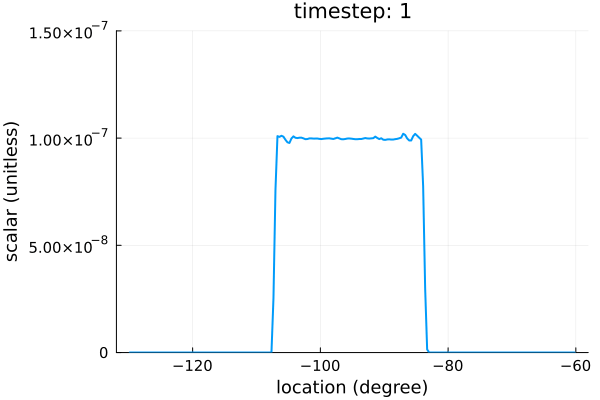

In [34]:
## Visualization in animation
anim = @animate for i ∈ 1:360
    plot(-130+0.3125/2:0.3125:-60-0.3125/2, history[1][:,8*i-7], title = string("timestep: ", string(8*i-7)), 
        ylims=(0.0,1.5e-7), xlabel="location (degree)", ylabel="scalar (unitless)", linewidth=2,
        xguidefont=12, yguidefont=12, xtickfont=10, ytickfont=10, legend=false)
    #, ylims=(0.0,3.0e-9)
    #plot!(0:34687.5*2:6937500, scalar_GEOS_Array_2x_16x[:,i], label = "numerical")
end
gif(anim, "anim_fps15.gif", fps = 15)